In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt

## Question 1

Download your data and print descriptive statistics for all columns.  How do maximum and minimum air temperature at 0.4 m compare to those at 2.0 m?


### Answer

See below for values (no need to compare all but check T_0.4 and T_2 to make sure they did the correct file).

Max/min values of T at 0.4m are higher/lower than at 2 m for all observations.  This means, T near the surface is more variable over the course of the day than T further from the surface

In [9]:
root='https://raw.githubusercontent.com/GEOS300/AssignmentData/main/CA_DBB_DailyData/'
# Empty dataframe containing all days
All_Data = pd.DataFrame()
for fn in ['20160620','20160808','20160811','20160812','20160813','20160817','20160729','20160730','20160820','20160821']:
    df = pd.read_csv(f'{root}{fn}.txt',parse_dates=['Date/Time (PST)'],index_col='Date/Time (PST)')
    All_Data = pd.concat([All_Data,df])

# Just a minor hack to get all timstamps on the "same" day for grouping by shifting 1s
# Otherwise Timstamps at midnight, get groupled as the "next" day
offset = pd.Timedelta('1s')
All_Data['Date'] = (All_Data.index-offset).date
for t in ['T_0.4m (K)','T_2m (K)']:
    print(All_Data[[t,'Date']].groupby('Date').describe().to_string())


           T_0.4m (K)                                                                   
                count        mean       std     min       25%      50%       75%     max
Date                                                                                    
2016-06-20       48.0  289.072500  6.256290  279.77  284.0075  289.525  294.8075  298.44
2016-07-29       48.0  295.258542  5.142718  287.04  290.1750  295.570  300.3625  302.73
2016-07-30       48.0  292.608958  4.480222  286.56  288.3475  291.580  297.4100  299.67
2016-08-08       48.0  288.876250  5.173618  280.27  285.2450  288.165  293.6000  298.01
2016-08-11       48.0  292.824375  7.335272  282.20  285.1625  294.660  299.6050  301.78
2016-08-12       48.0  294.084792  7.809806  283.52  285.9325  295.795  301.7075  304.87
2016-08-13       48.0  295.250000  7.106923  285.41  288.0925  296.975  302.2225  303.81
2016-08-17       48.0  294.025208  5.650053  285.81  288.4075  294.415  299.6650  301.68
2016-08-20       48.0

## Question 2

Convert the air temperature $T$ values at 0.4 m and 2.0 m to potential temperature $\Theta$.  Recalculate the descriptive statistics for $\Theta_{z=0.4}$ and  $\Theta_{z=2}$; how does this adjustment impact the values?

### Answer

Same patterns apply but differences are marginal because the distance between observation heights (1.6m) is very small. 


In [10]:
class Temp_Corrections:
  # Inputs: 
  # Required: T (temp in K), r_v (water vapor mixing ratio in mol/mol), z (height in m)
  # Optional: r_l (mixing ratio of liquid water in mol/mol), z_reff (reference height in m) 
  def __init__(self,T,r_v=0,z=0,r_l=0,z_reff=0):
    self.T,self.r_v,self.z = T,r_v,z
    self.r_l,self.z_reff=r_l,z_reff # Will be given defaults unless other are provided
    self.Potential_Temp()
    self.Virtual_Temp()
  def Potential_Temp(self):
    DALR = 0.01
    self.Theta = self.T+DALR*(self.z-self.z_reff)
  def Virtual_Temp(self):
    self.T_v = (1 + 0.61 * self.r_v - self.r_l) * self.T
    self.Theta_v = (1 + 0.61 * self.r_v - self.r_l) * self.Theta

# Variant of the example code I showed in lecture to do temperature corrections.  
# They don't need to implement it exactly like this as long as calculated values are correct
# *Note* just feeding a dummy variable for r_v at 0.4 m; don't have that observation (r_v only measured at 2m)
#  But its fine because the question doesn't ask for T_v or Theta_v, so r_v isn't used anyway
All_Data['Theta_0.4m (K)'] = Temp_Corrections(T=All_Data['T_0.4m (K)'],z=0.4).Theta
All_Data['Theta_2m (K)'] = Temp_Corrections(T=All_Data['T_2m (K)'],z=2).Theta

for t in ['Theta_0.4m (K)','Theta_2m (K)']:
    print(All_Data[[t,'Date']].groupby('Date').describe().to_string())

           Theta_0.4m (K)                                                                     
                    count        mean       std      min       25%      50%       75%      max
Date                                                                                          
2016-06-20           48.0  289.076500  6.256290  279.774  284.0115  289.529  294.8115  298.444
2016-07-29           48.0  295.262542  5.142718  287.044  290.1790  295.574  300.3665  302.734
2016-07-30           48.0  292.612958  4.480222  286.564  288.3515  291.584  297.4140  299.674
2016-08-08           48.0  288.880250  5.173618  280.274  285.2490  288.169  293.6040  298.014
2016-08-11           48.0  292.828375  7.335272  282.204  285.1665  294.664  299.6090  301.784
2016-08-12           48.0  294.088792  7.809806  283.524  285.9365  295.799  301.7115  304.874
2016-08-13           48.0  295.254000  7.106923  285.414  288.0965  296.979  302.2265  303.814
2016-08-17           48.0  294.029208  5.650053  2

## Question 3

From the data-set provided, calculate $H$, $LE$ and $F_{CO2}$ from the covariances of $\overline{w^{\prime}T^{\prime}}$, $\overline{w^{\prime}\rho_v^{\prime}}$, and $\overline{u^{\prime}\rho_{\rm{CO}_2}^{\prime}}$ respectively.  You can assume that the heat capacity of air is 0.0012 MJ m<sup>-3</sup> K<sup>-1</sup>.  You can estimate the density of air $\rho$ using the Ideal Gas Law @eq-Ideal-Gas-Law and you can estimate the latent heat of vaporization following @eq-Latent-Heat-Vaporization:



$$
PV=nRT
$${#eq-Ideal-Gas-Law}

here,$R$ is the ideal gas constant ($8.31446261815324 Pa\ m^3\ mol^{-1} K ^{-1}$), $T$ is temperature (in Kelvin!), $P$ is air pressure, $V$ is volume, $n$ is the amount of the gas in mols; with $n=m/M$, where $m$ is mass and $M$ is the molar mass.  The molar mass of air is $\approx 0.028964 kg mol^{-1}$

Following Yao & Rogers (1996), the latent heat of vaporization of water ($L_v$ in $J g^{-1}$) can be approximated as a function of temperature ($T$ in $^{\circ}C$) using a third order polynomial function:

$$
L_v = 2500.8-2.36*T-0.0016*T^2-0.00006*T^3
$${#eq-Latent-Heat-Vaporization}


### Answer

Not explicitly asked to show values here (will see them from plot/answers below) so just check for that the calculations were applied correctly.  OK if they don't print the values

In [5]:
# Get rho (air density) using ideal gas law
R = 8.31446261815324
M = 0.028964
All_Data['Pa (Pa)'] = All_Data['Pa (kPa)']*1e3
# Use ideal gas law to get density (rho)
# Note, not necessary to use potential or virtual potential temp here
# But don't deduct points they do use it
All_Data['rho'] = All_Data['Pa (Pa)']*M/(All_Data['T_2m (K)']*R)

# See: https://geos300.github.io/Lectures/18.html#/measuring-sensible-heat-flux-density-h-by-ec
c_a = 1.01 * 1e3
All_Data['H (W m-2)'] = All_Data['rho']*c_a*All_Data["w'T' (K m s-1)"]

# Using absolute temperature here is preferred, but don't take off if they use potential/virtual temp either
# **NOTE** The equation for L_v is an empirical fit takes T in deg C, so they'll need to convert
def get_Lv(T_k):
    T_c = T_k - 273.15
    LV = 2500.8-2.36*T_c-0.0016*T_c**2-0.00006*T_c**3
    return(LV)

All_Data['L_v'] = get_Lv(All_Data['T_2m (K)'])

# See https://geos300.github.io/Lectures/18.html#/latent-heat-flux-density-le\
All_Data['LE (W m-2)'] = All_Data['L_v']*All_Data["w'rho_v' (g m-2 s-1)"]

# See https://geos300.github.io/Lectures/18.html#/mass-trace-gas-flux
All_Data['Fc umol m-2 s-1'] = All_Data["w'rho_CO2' (micromol m-2 s-1)"]

for f in ['H (W m-2)','LE (W m-2)','Fc umol m-2 s-1']:

    print(All_Data[[f,'Date']].groupby('Date').describe().to_string())

           H (W m-2)                                                                               
               count       mean        std        min        25%        50%         75%         max
Date                                                                                               
2016-06-20      48.0  52.563532  66.101173 -20.594444  -0.283097  28.105259   70.852681  214.088854
2016-07-29      48.0  62.815025  93.612713 -45.384300 -21.213721  22.365251  161.146701  214.862137
2016-07-30      48.0  63.515954  97.587597 -37.737845 -18.817069  10.254530  171.260228  219.535305
2016-08-08      48.0  58.298484  94.408607  -8.190072  -0.310123   5.221598   97.036815  275.336506
2016-08-11      48.0  71.568827  91.483766 -33.355702  -0.315114  14.810060  159.593190  235.326012
2016-08-12      48.0  65.181752  79.150359 -20.708253   1.898895  10.298755  129.631269  227.449101
2016-08-13      48.0  59.359059  79.008721 -28.054408  -2.716598  13.015799  116.393111  207.193316


           LE (W m-2)                                                                              
                count       mean        std        min       25%        50%         75%         max
Date                                                                                               
2016-06-20       48.0  48.498235  66.383891 -19.607442  0.555862  27.491815   77.284102  259.752293
2016-07-29       48.0  65.351277  72.491340  -0.736752  1.845589  31.464285  123.855731  208.393864
2016-07-30       48.0  65.168862  76.367252  -8.356514  0.184100  24.592907  134.719166  228.115595
2016-08-08       48.0  34.665079  56.912280 -11.644863  0.246706   3.210348   55.510434  179.504363
2016-08-11       48.0  49.332525  54.133354  -3.466962  3.251443  23.513486   96.465227  173.150581
2016-08-12       48.0  56.882007  69.330824 -46.924638  1.905538  21.347419  118.653719  192.514571
2016-08-13       48.0  59.132887  70.170973  -8.376532  1.354998  31.671882   98.862107  202.877898


## Question 4

Create a graph with time of day on the $x$-axis and the three measured flux densities of the surface energy balance ($R_n$, $H$, $H$) on the $y$-axis. Briefly discuss their diurnal course.  Do $H$ and $LE$ sum to $R_n$?  If not, why?

### Answer

All fluxes are in W m-2. Units should be explicitly indicated (show here in legend for simplicity).

* All days will have similar patterns for each component: positive daytime, near zero or negative nighttime
    * Some days have clouds for part of the day which cause a notable drop in R_n, others are clear all day

* Rn has largest magnitude (postive and negative); H is generally larger magnitude than LE, but not for every observation

* The astute observer will note that LE lags a bit behind H

* H + LE do not sum

H + LE **do not** fully offset R_n.  Energy is going elsewhere: mainly ground heat flux & photosynthesis


              Closure
Date                 
2016-06-20  44.171085
2016-07-29  51.423260
2016-07-30  37.730597
2016-08-08  29.418563
2016-08-11  52.013746
2016-08-12  45.454952
2016-08-13  39.465248
2016-08-17  44.830745
2016-08-20  34.236475
2016-08-21  34.226864


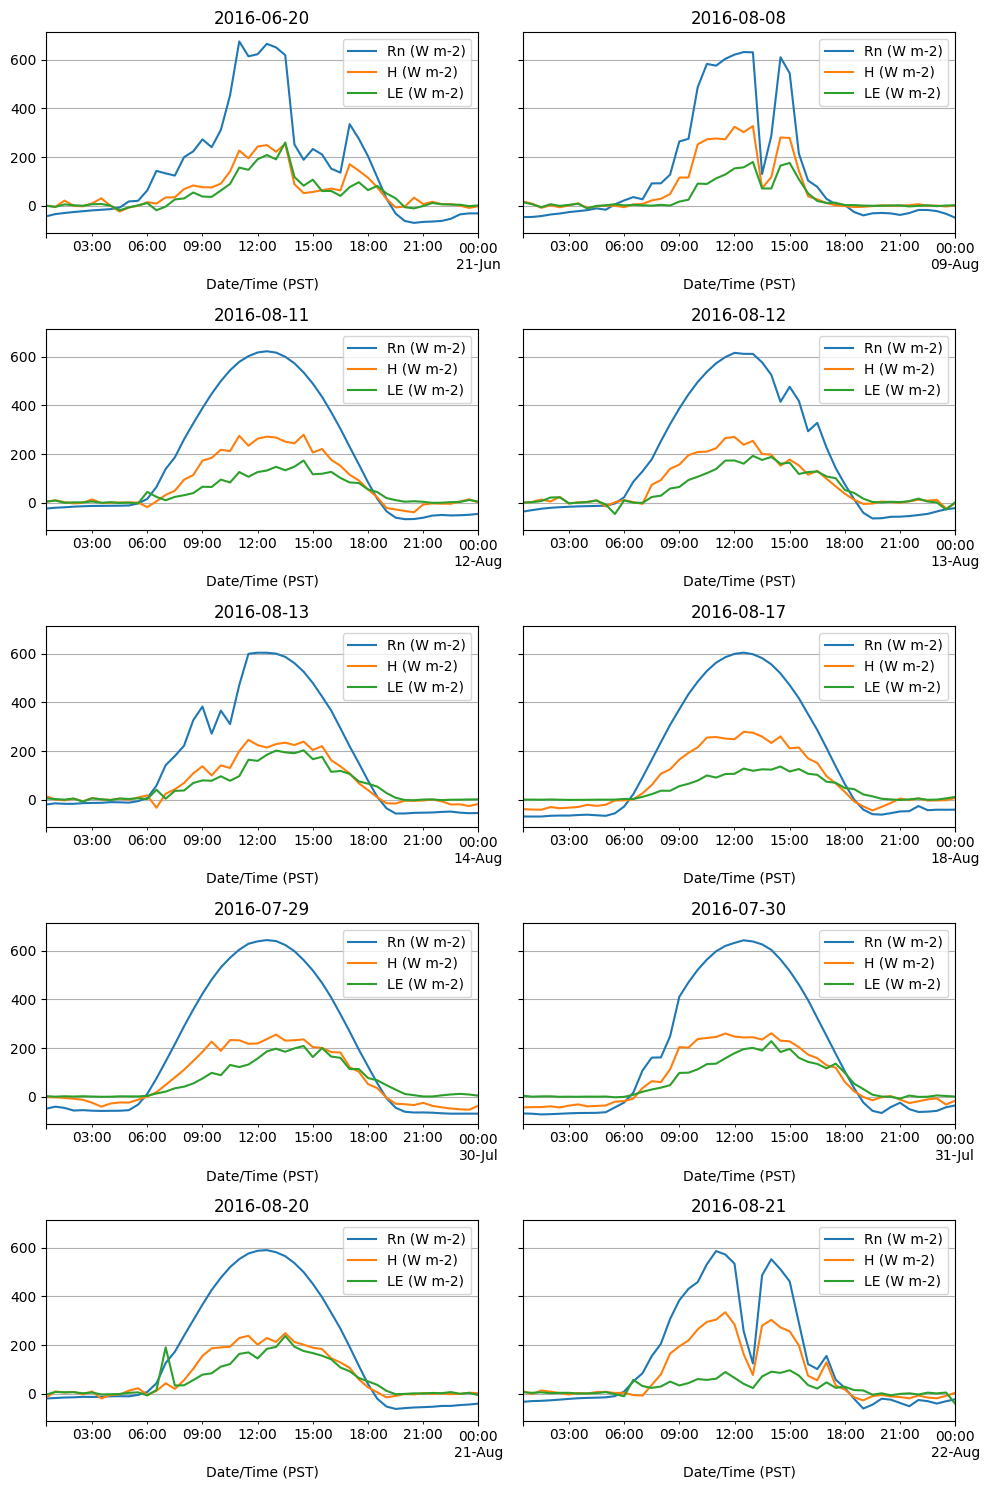

In [6]:
fig,ax=plt.subplots(5,2,figsize=(10,15),sharey=True)
ax=ax.flatten()

for i,date in enumerate(All_Data['Date'].unique()):
    All_Data.loc[All_Data['Date'] == date,['Rn (W m-2)','H (W m-2)','LE (W m-2)']].plot(ax=ax[i])
    ax[i].set_title(date)
    ax[i].grid()
plt.tight_layout()

# Do the energy fluxes balance?
All_Data['Closure'] = All_Data['Rn (W m-2)'] - All_Data[['H (W m-2)','LE (W m-2)']].sum(axis=1)

# To see if Rn is balanced by H and LE, you can get the residual component.
# Don't need to print the mean value.  There are other ways to prove the point.
print(All_Data[['Closure','Date']].groupby('Date').mean())

## Question 5

For 16:00, Calculate $H$ based on the aerodynamic method using the simultaneously measured profiles of $\overline{u}$ and $\overline{T}$. How does the value of $H$ compare to $H$ calculated from $\overline{w^{\prime}T^{\prime}}$? Why could it differ?

### Answer

They don't match because the aerodynamic approach using a method that assumes neutral stability conditions.



In [18]:
# See: https://geos300.github.io/Lectures/17.html#/aerodynamic-approach-33
k = 0.41

# Get Deltas
All_Data['Delta_u'] = All_Data['u_2m (m s-1)']-All_Data['u_0.4m (m s-1)']
All_Data['Delta_theta'] = All_Data['Theta_2m (K)']-All_Data['Theta_0.4m (K)']

# Apply gradient method:
All_Data['H gradient method (W m-2)'] = -All_Data['rho']*k**2*All_Data['Delta_u']*c_a*All_Data['Delta_theta']/(np.log(2/0.4)**2)
All_Data.loc[((All_Data.index.hour==16)&(All_Data.index.minute==0)),
             ['H (W m-2)','H gradient method (W m-2)']]

,H (W m-2),H gradient method (W m-2)
Date/Time (PST),,
2016-06-20 16:00:00,69.944890,57.822463
2016-08-08 16:00:00,38.221304,71.110289
2016-08-11 16:00:00,176.166104,392.577390
2016-08-12 16:00:00,115.054631,189.527251
2016-08-13 16:00:00,162.177446,258.373580
2016-08-17 16:00:00,169.192234,416.530736
2016-07-29 16:00:00,183.303828,343.522720
2016-07-30 16:00:00,172.924842,246.703993
2016-08-20 16:00:00,145.229541,140.691034



## Question 6

Using the covariances and the profile measurements, calculate the eddy diffusivities for sensible heat $K_H$ and momentum $K_M$ at 16:00. Is Reynold's analogy fulfilled or not at 16:00?

### Answer:

It is not fulfilled, because K_M does not equal K_H here

In [23]:
# Substitute eq 4 from here (https://geos300.github.io/Lectures/18.html#/measuring-sensible-heat-flux-density-h-by-ec) 
# for H from here: https://geos300.github.io/Lectures/17.html#/k-theory
# then rearrange and solve to get K_H

delta_z = 1.6
All_Data['K_H'] = -All_Data["w'T' (K m s-1)"]*delta_z/All_Data['Delta_theta']

# Substitute time-averaged tau from here: https://geos300.github.io/Lectures/15.html#/reynolds-stress-and-covariance
# Into tau here: https://geos300.github.io/Lectures/17.html#/k-theory
# Then rearrange, cancel terms, and solve for K_m

All_Data['K_M'] = -All_Data["u'w' (m2 s-2)"]*delta_z/All_Data['Delta_u']

print(All_Data.loc[((All_Data.index.hour==16)&(All_Data.index.minute==0)),
             ['K_H','K_M']])

                          K_H       K_M
Date/Time (PST)                        
2016-06-20 16:00:00  0.125603  0.137280
2016-08-08 16:00:00  0.043532  0.110974
2016-08-11 16:00:00  0.053118  0.174035
2016-08-12 16:00:00  0.051057  0.138864
2016-08-13 16:00:00  0.061916  0.159158
2016-08-17 16:00:00  0.050190  0.176672
2016-07-29 16:00:00  0.081447  0.197769
2016-07-30 16:00:00  0.082243  0.172460
2016-08-20 16:00:00  0.080388  0.144213
2016-08-21 16:00:00  0.275374  0.162462



## Question 7

For 16:00, calculate the Obukhov-length $L$ and the stability parameter $\zeta = z/L$. Does $\zeta$ qualitatively agree with $Rf$? Is $\zeta = z/L$ really indicating `neutral' as assumed in using the aerodynamic method above?

### Answer

Should use virtual potential temp for L, but if they use Absolute or Potential temp, just apply a small penalty (1pt), it'll be close enough.

All values of $\zeta$ are negative indicating unstable conditions, so the neutral assumption does not apply.

In [27]:
# L is explicitly defined using virtual potential temp: https://geos300.github.io/Lectures/19.html?q=Obuk#/monin-obukhov-similarity-theory
# So they need to calculate that first (calling a method defined in Eq 2 answer)
All_Data['Theta_V_2m (K)'] = Temp_Corrections(T=All_Data['T_2m (K)'],r_v=All_Data['rv'],z=2).Theta_v
# Can get u* from here: https://geos300.github.io/Lectures/15.html?q=fricti#/friction-velocity
All_Data['u*'] = (-All_Data["u'w' (m2 s-2)"])**.5

g = 9.8 # m s-2
k = 0.41 

All_Data['L'] = - All_Data['rho']*c_a*All_Data['Theta_V_2m (K)']*(All_Data['u*']**3)/(k*g*All_Data['H (W m-2)'])
All_Data['zeta'] = 2/All_Data['L']

print(All_Data.loc[((All_Data.index.hour==16)&(All_Data.index.minute==0)),
             ['L','zeta']])

                             L      zeta
Date/Time (PST)                         
2016-06-20 16:00:00 -38.442148 -0.052026
2016-08-08 16:00:00 -34.986935 -0.057164
2016-08-11 16:00:00 -26.513049 -0.075435
2016-08-12 16:00:00 -17.306248 -0.115565
2016-08-13 16:00:00 -19.085710 -0.104790
2016-08-17 16:00:00 -30.020655 -0.066621
2016-07-29 16:00:00 -44.903702 -0.044540
2016-07-30 16:00:00 -26.091924 -0.076652
2016-08-20 16:00:00 -12.833008 -0.155848
2016-08-21 16:00:00 -69.532807 -0.028763


## Question 8

In the process of photosynthesis, energy is extracted from photons in the PAR range. To assimilate one mole of $\rm{CO}_2$, it requires an energy of 469 kJ. The same amount is released back during respiration (metabolism, decomposition of organic matter). We call this energy flux density the *net biochemical energy storage* $\Delta P$. Calculate $\Delta P$ at 13:00 in $\rm{W}\,\rm{m}^{-2}$. At 13:00, what fraction of $R_n$ is used up in the process of photosynthesis? Is $\Delta P$ a relevant term in the surface energy balance of this bog or not?

### Answer:

All $|\Delta_P| < 2$, its a small proportion of $R_n$ in all cases < 0.3%

* Note, be flexible with sign convention > positive or negative answers are fine.  Fc is negative indicating the ecosystem is CO2 sink.  However, from the energy balance perspective, the energy required to assimilate CO2 is another outlet for R_n.  Accumulation of energy in the vegetation would be positive $\Delta_P$

In [33]:
# Take F_c and convert from umol to mol
# Then multiply by the energy of assimilation to get Delta P

All_Data['Fc mol m-2 s-1'] = All_Data['Fc umol m-2 s-1']*1e-6
e_assimliation = 469*1e3 #kJ

All_Data['Delta_P'] = -All_Data['Fc mol m-2 s-1']*e_assimliation
All_Data['P_frac'] = All_Data['Delta_P']/All_Data['Rn (W m-2)']

print(All_Data.loc[((All_Data.index.hour==13)&(All_Data.index.minute==0)),
             ['Delta_P','P_frac']])


                      Delta_P    P_frac
Date/Time (PST)                        
2016-06-20 13:00:00  1.880596  0.002887
2016-08-08 13:00:00  0.967875  0.001534
2016-08-11 13:00:00  0.870464  0.001410
2016-08-12 13:00:00  1.428339  0.002333
2016-08-13 13:00:00  0.962482  0.001601
2016-08-17 13:00:00  0.598163  0.000999
2016-07-29 13:00:00  1.057595  0.001652
2016-07-30 13:00:00  0.757435  0.001186
2016-08-20 13:00:00  0.496671  0.000853
2016-08-21 13:00:00  0.178689  0.001441


## Question 9

Determine the average carbon dioxide ($\rm{CO}_2$) flux density between the bog and the atmosphere for this day and convert it to $\rm{g}\,\rm{CO}_2\,\rm{m^{-2}}\,\rm{day}^{-1}$. Is the surface a net sink or net source for atmospheric $\rm{CO}_2$ on this day?  Note: the molar mass of $\rm{CO}_2$ 44.01 $g mol^{-1}$

### Answer

The site is a sink when Fc is negative or a source when positive.  Will vary by day

In [35]:
# Sum by day and scale (using molar mass of CO2) convert from seconds to half-hour (1800 secs)
# Answer is now in g m-2 d-1
All_Data.groupby('Date')['Fc mol m-2 s-1'].sum()*44.01*1800

Date
2016-06-20   -3.918914
2016-07-29    0.382005
2016-07-30   -0.655648
2016-08-08   -0.308000
2016-08-11    0.441213
2016-08-12    0.191581
2016-08-13    1.273897
2016-08-17    0.688325
2016-08-20    1.152123
2016-08-21    0.472440
Name: Fc mol m-2 s-1, dtype: float64





:::: {.columns}

# Extra Credit: Self guided field trip

**Note** the extra credit is due with the final exam.  Don't submit the extra credit with Assignment 4!  There will be a space to upload your extra credit on canvas in the exam!

The CA-DBB eddy covariance station is located within the Burns Bog Ecological Conservancy Area.  It is a large peatland area that is being actively managed to restore the the ecosystem after decades of peat harvesting and mismanagement.  Public access to the bog is prohibited, so we can't take a field trip to visit the site.  However, you can visit a (much smaller) restored peatland, which is only 30 minutes away from UBC!  The [Camosun Bog](http://camosunbog.ca/restoration-methods/) is a restored remnant of a once much larger peat bog, located on the eastern edgy of Pacific Spirit Park.  The entrance to the bog is a 6 minute walks south along Camosun street from 16th avenue, and it can easily accessible from UBC by bus via the 25 or 33 bus @fig-Camosun-Map.  The bog has a short elevated boardwalk @fig-Camosun-Map2 path with informational signs @fig-Camosun-Sign that allows visitors to explore this unique urban-peatland without disturbing the fragile ecosystem.  The bog is centered on "Devils Hole", a restored pond area surrounded by a small open sphagnum peatland that grades into the surrounding forested landscape.

![Transit access to Camosun Bog](../images/Camosun.png){#fig-Camosun-Map}

![Illustrative map of Camosun Bog](http://camosunbog.ca/wp-content/uploads/2017/12/26036951_525706821133853_1428030430_o-768x564.png){#fig-Camosun-Map2}

![Pond in Camosun Bog](../images/Camosun2.png){#fig-Camosun-Sign}

![Informational Signage at Camosun Bog](../images/Camosun_sign.jpg){#fig-Camosun-Pond}

## Extra Credit Tasks!

1. Visit the Camosun Bog!  Go to the Camosun Bog, walk around the boardwalk area, read the interpretive signs, and check out the unique ecosystem.   Take a selfie from the bog (or group photo if you visit with classmates!) with the bog clearly visible in the background to verify your visit.  If you aren't comfortable taking a selfie, a photo from the bog that includes your student number written on a piece of paper with the bog clearly visible in the background is also sufficient to verify your visit.

2. Write a brief description of the bog (1 paragraph).  How does it compare (sights, sounds, smells) to the surrounding area (forest and residential neighborhood).

3. The Camosun Bog restoration group is interested in measuring the water balance of the bog to ensure their restoration efforts will be effective over the long-term in a changing climate.  They are considering installing an eddy covariance system, similar to the CA-DBB eddy covariance station in Burns Bog to measure evapotranspiration at the site.  Do you think this would be an effective approach at this location?  Why or why not?  *Hint* you can zoom out / pan / zoom in on the map from assignment 4 to view the Camosun Bog with high resolution satellite imagery. 


::::
